In [18]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.models as models

import wandb

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
saved_model_folder = "./saved_models"
os.makedirs(saved_model_folder, exist_ok=True)

### Data Loading and Processing

In [4]:
def build_people_dict(csv_path, root_dir):
    """
    This function takes the CSV file and creates a dictionary of file paths corresponding to each person in the CSV file.
    """
    df = pd.read_csv(csv_path)
    people_dict = defaultdict(list)
    
    for idx, row in df.iterrows():
        person_name = row['name']
        num_images_expected = row['images']
        
        # Get full folder path
        person_folder = os.path.join(root_dir, person_name)
        
        file_extensions = ('.jpg', '.jpeg', '.png')
        if os.path.exists(person_folder):
            image_files = []
            for file in os.listdir(person_folder):
                if file.endswith(file_extensions):
                    image_files.append(file)
                image_files = sorted(image_files)
    
                # Build the full paths for the images
                full_paths = [os.path.join(person_folder, img_file) for img_file in image_files]
                
                people_dict[person_name].extend(full_paths)
        else:
            print(f"No folder found for person: {person_name}")
    
    return dict(people_dict)

In [5]:
train_csv = "/home/user/javeda1/lwf_dataset/peopleDevTrain.csv"
test_csv = "/home/user/javeda1/lwf_dataset/peopleDevTest.csv"
root_dir = "/home/user/javeda1/lwf_datasets"  # Folder containing image subfolders

people_dict_train = build_people_dict(train_csv, root_dir)
people_dict_test = build_people_dict(test_csv, root_dir)

In [7]:
class LFWDataset(Dataset):
    def __init__(self, people_dict, transform=None, num_samples=10000):
        self.people_dict = people_dict
        self.person_ids = list(people_dict.keys())
        self.transform = transform
        self.num_samples = num_samples
        
        self.label2id = {person: idx for idx, person in enumerate(self.person_ids)}

    def __len__(self):
        return len(self.people_dict)

    def __getitem__(self, idx):
        # Sample a random person for the anchor
        anchor_person = random.choice(self.person_ids)
        
        # Get positive and negative anchors
        if len(self.people_dict[anchor_person]) < 2:
            # Recursively call the function until an anchor person with >= 2 images is found
            return self.__getitem__(random.randint(0, self.num_samples - 1))
        
        anchor_path, positive_path = random.sample(self.people_dict[anchor_person], 2)
        
        negative_person = random.choice(self.person_ids)
        # Again while loop till a different person is found.
        while negative_person == anchor_person or len(self.people_dict[negative_person]) < 1:
            negative_person = random.choice(self.person_ids)
        negative_path = random.choice(self.people_dict[negative_person])
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)


        anchor_label = self.label2id[anchor_person]
        positive_label = anchor_label
        negative_label = self.label2id[negative_person]

        return anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label

In [11]:
train_transform = transforms.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

In [13]:
# Create the Datasets
train_dataset = LFWDataset(people_dict_train, transform=train_transform)
test_dataset = LFWDataset(people_dict_test, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

### Visualize Dataset

In [15]:
def minmax_normalize(tensor):
    # Min-max normalization
    tensor_min, tensor_max = tensor.min(), tensor.max()
    return (tensor - tensor_min) / (tensor_max - tensor_min)


def visualize_triplet_samples(dataset, n=5):
    """
    Visualize n samples from the TripletDataset using Min-Max normalization.
    """

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 3*n))

    for i in range(n):
        # Fetch one item
        anchor, positive, negative, _, _, _ = dataset[i]

        # Apply Min-Max normalization
        anchor_disp = minmax_normalize(anchor)
        positive_disp = minmax_normalize(positive)
        negative_disp = minmax_normalize(negative)

        anchor_np = anchor_disp.permute(1, 2, 0).cpu().numpy()
        positive_np = positive_disp.permute(1, 2, 0).cpu().numpy()
        negative_np = negative_disp.permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(anchor_np)
        axes[i, 1].imshow(positive_np)
        axes[i, 2].imshow(negative_np)
        
        axes[i, 0].set_title("Anchor")
        axes[i, 1].set_title("Positive")
        axes[i, 2].set_title("Negative")
        
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

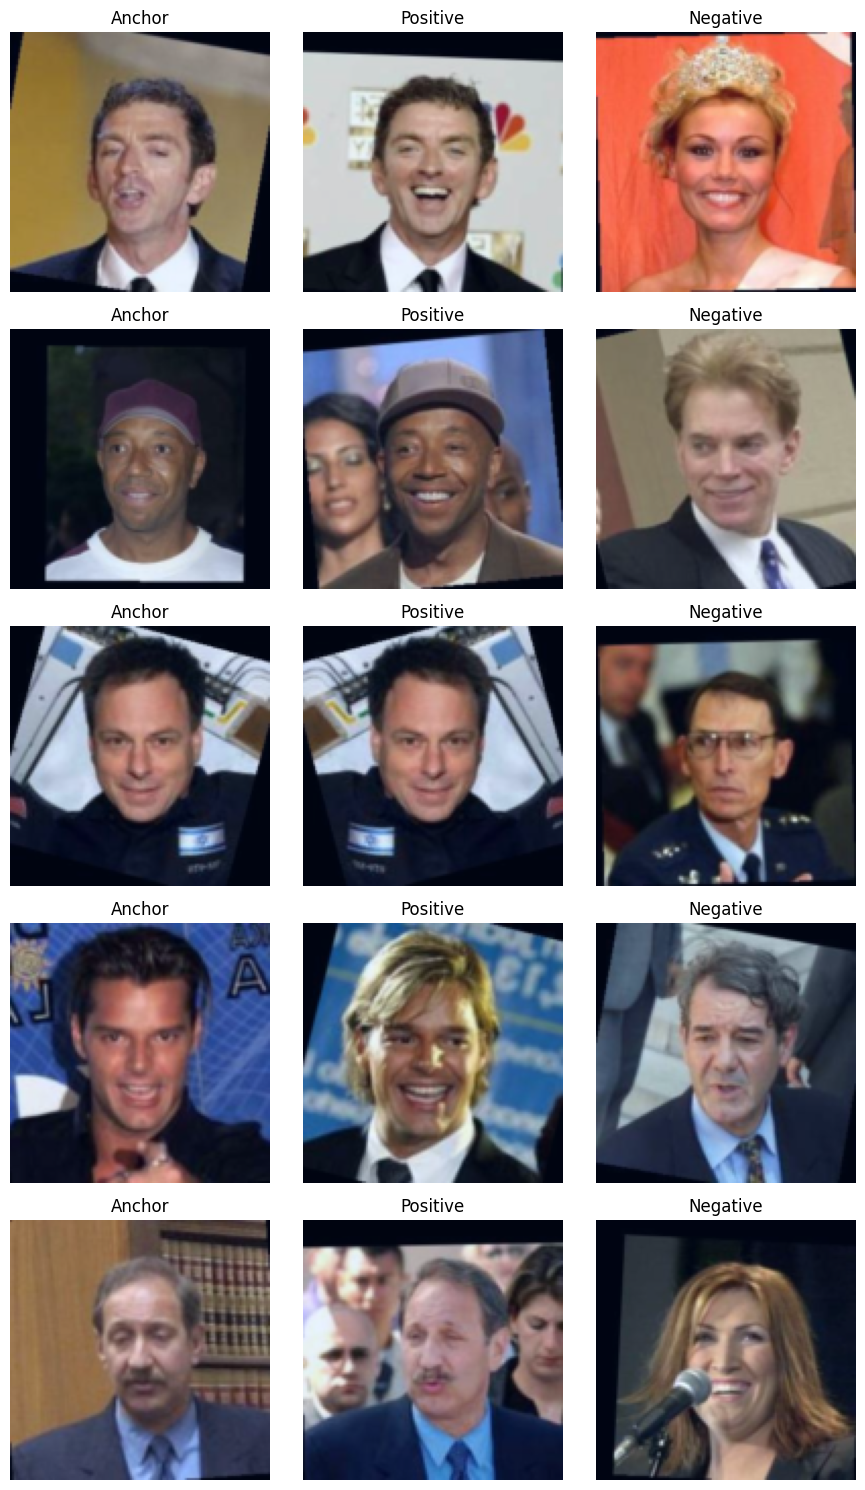

In [16]:
visualize_triplet_samples(train_dataset, n=5)

### Model architecture

In [17]:
class TriNet(nn.Module):
    def __init__(self, embedding_dim=128, pretrained=True):
        super(TriNet, self).__init__()
        #ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Remove the last FC
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  
        
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        
        return x

### Training Code

In [19]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Trains the model for one epoch """
    model.train()
    running_loss = 0.0
    
    for anchor, positive, negative, _, _,_ in dataloader:
        anchor   = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_emb   = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def eval_one_epoch(model, dataloader, loss_fn, device):
    """Evaluates the model after each epoch."""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for anchor, positive, negative, _, _, _ in dataloader:
            anchor   = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_emb   = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def train(model, train_dataloader, val_dataloader, optimizer,
          device, epochs=10, margin=0.5,
         project="my_trinet-project", name='test_run-1'):

    
    # Initialize W&B
    wandb.init(project=project, name=name, config={
        "epochs": epochs,
        "margin": margin,
        "learning_rate": optimizer.param_groups[0]["lr"]
    })

    # triplet loss
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, triplet_loss_fn, device)
        val_loss   = eval_one_epoch(model, val_dataloader, triplet_loss_fn, device)
        
        #learning rate
        current_lr = optimizer.param_groups[0]["lr"]

        # Log metrics to wandb
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": current_lr,
            "epoch": epoch + 1
        })

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Finish wandb run
    wandb.finish()

    return model

### Load Model

In [20]:
def load_model(model_path):
    """
    Load a saved model
    """
    model = torch.load(model_path)
    return model

In [ ]:
# Paramters
margin=0.2
epochs=5
project='trinet_model'
name='test_run1'
# name=f"margin_{margin}_ep_{epochs}"

model = TriNet(embedding_dim=128).to(device)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train model
model = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    margin=margin,
    name=name,
    project=project
)

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


 20%|███████████▏                                            | 1/5 [03:09<12:38, 189.74s/it]

Epoch [1/5] Train Loss: 0.0444 | Val Loss: 0.0382 | LR: 0.000100


 40%|██████████████████████▍                                 | 2/5 [03:54<05:13, 104.59s/it]

Epoch [2/5] Train Loss: 0.0215 | Val Loss: 0.0307 | LR: 0.000100


 60%|██████████████████████████████████▏                      | 3/5 [04:24<02:20, 70.27s/it]

Epoch [3/5] Train Loss: 0.0181 | Val Loss: 0.0284 | LR: 0.000100
